In [4]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install flatbuffers
!{sys.executable} -m pip install gravis
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install numba

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.

In [78]:
import sys
import numpy as np
import matplotlib.pyplot as plt 
import os
taz_path = os.path.join(os.getcwd(),"../../")
sys.path.append(os.path.join(taz_path,"scripts"))
import taz
from taz import matrix
from taz import snapshot
import generate_apps_traffic as gen
import fbs
import pandas as pd
import glob
import math
import statistics 

# To play with libraries themselves
# import importlib
# importlib.reload(gen)
# importlib.reload(taz)
# importlib.reload(taz.matrix)
# importlib.reload(fbs)

def open_single_run_result(run_result_folder, retrieve_mappings, retrieve_snapshots ) :
    jobs_file=os.path.join(run_result_folder,"jobs_0.csv")
    if not os.path.exists(jobs_file):
        return None
    jobs = pd.read_csv(jobs_file)
    stats = pd.read_csv(os.path.join(run_result_folder,"stats_0.csv"))
    mappings={}
    if retrieve_mappings:
        for mapping_file in glob.glob(f"{run_result_folder}/mapping*"):
            mat= taz.matrix.Matrix()
            mat.read(mapping_file)
            mappings[os.path.basename(mapping_file)]=mat.np_array
    
    snapshots={}        
    if retrieve_snapshots:
        for snapshot_file in glob.glob(f"{run_result_folder}/snap_*"):
            s=taz.snapshot.Snapshot(snapshot_file)
            snapshots[os.path.basename(snapshot_file)]=s

    completed_jobs=jobs[jobs['endtype']=='COMPLETION']
    n_failed_jobs=len(jobs[jobs['endtype']!='COMPLETION'])
    nominal=sum(completed_jobs['nominal'])
    nominal_node_time=sum(completed_jobs['nominal']*completed_jobs['nnodes']*completed_jobs['nnodes'])
    runtime=sum(completed_jobs['end']-completed_jobs['start'])
    count=completed_jobs.shape[0]
    #print(f"Got {nominal=} {runtime=} {count=}")

    return {'jobs': jobs, 'x': [nominal,runtime,nominal_node_time,count,n_failed_jobs], 'stats':stats, 'mappings':mappings , 'snapshots':snapshots}
        

def open_mapping_job_results( job_result_folder, retrieve_mappings, retrieve_snapshots ):
    base_folder = taz_path + "/" + job_result_folder
    if not os.path.exists(base_folder):
        print(f"The result folder {base_folder} does not exist!")
        return None 
    results=[]
    for log10_failure_rate in range(9,14):
        run_result_folder = taz_path + "/" + job_result_folder + "/mapping_experiment_traffic_m" + str(log10_failure_rate)
        #print(f"For {log10_failure_rate=} seed 0:")
        d=open_single_run_result(run_result_folder, retrieve_mappings, retrieve_snapshots )
        if d:
            d['log10_failure_rate']=log10_failure_rate
            d['seed']=0
            results.append(d)
        for run_result_seed_folder in glob.glob(f"{run_result_folder}/seed*"):
            seed_str=run_result_seed_folder[run_result_seed_folder.rindex("seed")+4:]
            #print(f"For {log10_failure_rate=} seed {seed_str}:")
            d=open_single_run_result(run_result_seed_folder, retrieve_mappings, retrieve_snapshots )
            if d:
                d['log10_failure_rate']=log10_failure_rate
                d['seed']=int(seed_str)
                results.append(d)

    return results

In [63]:
results_uniform=open_mapping_job_results( "results_mapping_traffic_uniform_traffic", False,False )
results_profile=open_mapping_job_results( "results_mapping_traffic_app_profile", False,False )

In [64]:
mat_uniform=np.ndarray((len(results_uniform),10))
for index,x in enumerate(results_uniform):
    mat_uniform[index,0]=x['log10_failure_rate']
    mat_uniform[index,1]=x['seed']
    mat_uniform[index,2:]=x['x'] + [sum(x['jobs']['endtype']=='LINK_FAILURE'),sum(x['jobs']['endtype']=='HOST_FAILURE'),sum(x['jobs']['endtype']=='TIMEOUT') ]

mat_profile=np.ndarray((len(results_profile),10))
for index,x in enumerate(results_profile):
    mat_profile[index,0]=x['log10_failure_rate']
    mat_profile[index,1]=x['seed']
    mat_profile[index,2:]=x['x'] + [sum(x['jobs']['endtype']=='LINK_FAILURE'),sum(x['jobs']['endtype']=='HOST_FAILURE'),sum(x['jobs']['endtype']=='TIMEOUT') ]


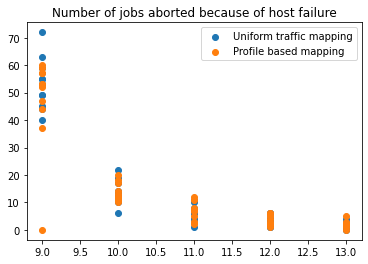

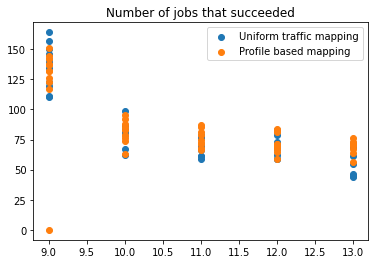

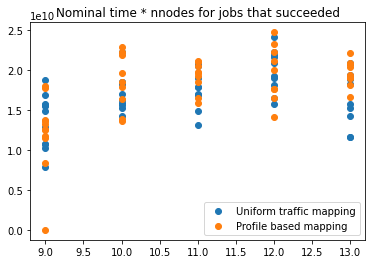

In [65]:
#2: nominal,3: runtime, 4: nominal_node_time,5: n_completed_jobs, 6: n_failed_jobs, 
#7: job aborted because of link failure, 8: job aborted because of jost failure, 9: job aborted because of timeout
ydim=8
plt.scatter(mat_uniform[:,0], mat_uniform[:,ydim])
plt.scatter(mat_profile[:,0], mat_profile[:,ydim])
plt.title("Number of jobs aborted because of host failure")
plt.legend(["Uniform traffic mapping","Profile based mapping"])

plt.figure()
ydim=5
plt.scatter(mat_uniform[:,0], mat_uniform[:,ydim])
plt.scatter(mat_profile[:,0], mat_profile[:,ydim])
plt.title("Number of jobs that succeeded")
plt.legend(["Uniform traffic mapping","Profile based mapping"])

plt.figure()
ydim=4
plt.scatter(mat_uniform[:,0], mat_uniform[:,ydim])
plt.scatter(mat_profile[:,0], mat_profile[:,ydim])
plt.title("Nominal time * nnodes for jobs that succeeded")
plt.legend(["Uniform traffic mapping","Profile based mapping"])



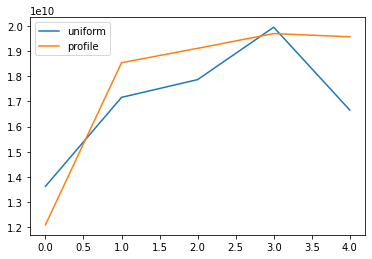

In [83]:

ydim=4
uniform_avg= [ statistics.mean(mat_uniform[mat_uniform[:,0]==f,ydim]) for f in range(9,14) ]
profile_avg= [ statistics.mean(mat_profile[mat_profile[:,0]==f,ydim]) for f in range(9,14) ]
plt.plot(uniform_avg)
plt.plot(profile_avg)
plt.legend(["uniform","profile"])


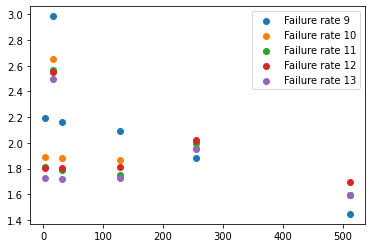

In [53]:
d_complete={}
d_fail={}
def increment_entry(d, nnodes, failure_rate):
    if not nnodes in d:
        d[nnodes]={failure_rate : 1 }
        return
    if not failure_rate in d[nnodes]:
        d[nnodes][failure_rate]=1
    else:
        d[nnodes][failure_rate]+=1
        
for index,x in enumerate(results_uniform):
    failure_rate=x['log10_failure_rate']
    #print(f"{type(x['jobs'])=}")
    for index2,x2 in x['jobs'].iterrows():
        #print(f"{x2=} {type(x2)=}")
        if x2['endtype'] == "COMPLETION":
            increment_entry(d_complete, x2['nnodes'], failure_rate)
        else:
            increment_entry(d_fail, x2['nnodes'], failure_rate)

app_sizes=list(set(list(d_complete.keys()) + list(d_fail.keys()) ))
app_sizes.sort()
    
for f in range(9,14):
    success=[math.log10(d_complete[s][f]) for s in app_sizes ]
    plt.scatter(app_sizes , success)

plt.legend([f"Failure rate {f}" for f in range(9,14)])


In [12]:
mat_uniform[:,3]

array([], dtype=float64)